In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

## Single object trackng problem
Single object tracking - we know that there is a precisely 1 object

- no need to infer number of objects
- fewer data association hypotheses

3 closely related challenges due to more complicated measurement model

- missed detections - object detected with imperfect sensor that apart from the noise has the porbability of detection $P^D(x) \le 1$
- clutter detections - false detections that dont correspond to any object
- unknown data association - at any time its unknown which of given detections (if any) is an object detection 

### Useful statistical background

#### Some links
- [good link to datacamp](https://www.datacamp.com/community/tutorials/probability-distributions-python)
- [another good one YouTube crash course statistics](https://www.youtube.com/watch?v=WR0nMTr6uOo)

#### Bernoulli distribution

$p^k(p-1)^{1-k}$

Probability of success or a failure of an event with 1 trial is described by follow Bernoulli distribution (heads/tails, true/false quiz, for/against vote, detection/no detection, infected/not infected zombie). Here $k \in \lbrace0,1\rbrace$ Where $k = 1$ is sucess and $k = 0$ is failure.

Example:

[0.8 0.2 0.  0. ]


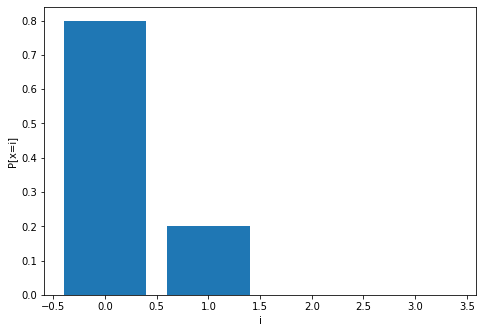

In [2]:
b = ss.bernoulli(0.2)
x = [0, 1, 2, 3]
p = b.pmf(x)
print(p)

# plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x,p)
ax.set_ylabel('P[x=i]')
ax.set_xlabel('i')
plt.show()

#### Binomial distribution

The Bernoulli distribution is a special case of the binomial distribution where a single trial is conducted. Binomial distribution can also be understood as performing Bernoulli distribution multiple times in a row, using logical AND which corresponds to multiplication of probabilities.

$\binom{n}{k}p^k(p-1)^{n-k}$

Consider having a toaster with 20% probability to hit you with electric shock when making a toast.  You eat a toast every work day. What is the probability of getting hit 1 time during the work week.

Binomial formula contains 2 key parts:
- $p^k(p-1)^{n-k}$ accounts for the probability that event happens k out of n times and does not happen the rest of the times. In our example the probability of getting 1 shock on monday and 0 shocks during the rest of the week $0.2^1 0.8^{5-1} = 8.2\%$
- $\binom{n}{k}$ binomial coefficient accounts for in how many ways the specific event can happen. For our example we can get that one shock either early in the week or monday, or tuesday or any other day of the work week.  There are $n=5 \text( choose ) k=1$ or $\binom{5}{1} = 5$. There are 5 different ways we can receive one toaster shock during the week.

$\binom{5}{1}0.2^1 0.8^{5-1} = 41\%$

Lets look at another example. There is a 5% chance to that a person you meet on a way to a shelter is a zombie. There are 20 zombies on your way and you can only safely get to the shelter if you meet maximum 2 zombies. What is the probability of getting to the shelter.

In [3]:
# binomial distribution object
b = ss.binom(20, 0.05)
total_p = 0
for k in range(0,3):
    total_p += b.pmf(k)
print(total_p)

0.9245163262115033


The expected value of the Binomial distribution is $\mathbb{E}(x) = pn$

### Poisson distribution
Models number of events in a given interval (fx, but also other dimension like area). For example, the number of users visited on a website in an interval can be thought of a Poisson process. In our application its the number of clutter detections that can be modelled by Poisson. The events must be intependent as to say knowing how many clutter detections we have in time $t$ gives no information in determining how many clutter detections occur at time $t+1$. An event can occur $0,1,2,...$ times in an interval. The average number of events or event rate in an interval is designated $\lambda > 0$. The probability of observing $k$ events in an interval is given by the equation:

$$Po(X=k) = e^{-\lambda}\frac{\lambda^k}{k!}$$

On average student ask you 4 questions per day. Yesterday they asked 7 questions, what was the likelihood of that? In this question the event rate is $\lambda=4$ and the amount of events is $k=7$, furthermore the time interval is 1 day.

The expected value and variance is $\lambda$

### Measurement model
The application of SOT requires the extension of the original measurement model used in the Bayesian filtering framework. In particular we would like to account not only for the uncertain detections, but also for missing object detections and extra detections that dont correspond to the object also known as clutter.

### Measurement model acounting for non-zero probability of misdetection
The object is detected with probability of detection $ P^D(x)$ The probability of detection can be constant or depending on x, for example if x is predicted to be out of our sensors sight we know that probability of detection must be 0. The measurement model generates measurement from true state:

$p(o_k|x_k) = g_k(o_k|x_k)$

Object detection measurement is often assumed

$o_k = h_k(x_k) + v_k$ where $ v_k \backsim \mathcal{N}(0,R_k)$ so that $ g_k(o_k|x_k) = \mathcal{N}(o_k:h_k(x_k),R_k)$

Detections are represented with a matrix, or sequence. For SOT the O_k contains at most 1 vector with measurement. The point object model assumption says that there is 0 probability of the object to generate more than 1 detection.
$$O_k = \begin{cases} [] &\text{if object is undetected} \\ o_k &\text{if object is detected} \end{cases}$$

Number of column vectors in $O_k$ is represented as $|O_k|$ and given $x_k$, $|O_k|$ is Bernoulli distributed (1 with $P^D$ otherwise 0):

$$|O_k| = \begin{cases} 1 &\text{with probability }P^D(x_k) \\ 0 &\text{with probability }1-P^D(x_k)\end{cases}$$

Combining two concepts above we arrive at the distribution of object measurement matrix. It captures both **the probability of detection** and if detected **the distribution of the detection**:
$$p(O_k|x_k) = \begin{cases} 1-P^D(x_k) &\text{if }O_k = [] \\ P^D(x_k)g_k(o_k|x_k) &\text{if } O_k = o_k \end{cases}$$

Interpretation of the first part is that the undetected measurement is equally likely to be found anywhere no matter $x_k$, so in the update step we are essentially not feeding any new information, just scaling the result of the prior (motion model) by the factor $1 - P^D(x_k)$

Lets generate a few samples from that distribution. Lets assume $P^D(x_k) = 0.85$ and $g_k(o_k|x_k) = \mathcal{N}(o_k:[3, 2]^T, 0.3\mathbf{I})$
    [FilterPy]() is used to plot the covariance ellipse

In [8]:
from numpy.random import rand
from filterpy.stats import plot_covariance_ellipse

def sample_Ok(p, gk, **kwargs):
    '''Sample from measurement function gk
    with probability of detection p'''
    O_k = []
    if rand() < p:
        o_k = gk(**kwargs)
        O_k.append(o_k)
    return O_k

def gk(x, P, N=1):
    '''Produce N realizations from multivariate 
    Gaussian measurement model with mean x and 
    covariance matrix P'''
    return np.random.multivariate_normal(x, P, N)

def simulate_Ok_samples(pd, x, P):
    o_k = sample_Ok(pd, gk, **{"x":x, "P":P})
    print("o_k: ",o_k)
    ax = plt.axes()
  
    plot_covariance_ellipse(x, P, fc='b',
                        alpha=0.2, std=[1, 2, 3])
    if o_k:
        ax.plot(o_k[0][:,0], o_k[0][:,1], "rs")
    ax.set_xlim(-2,6)
    ax.set_ylim(-2,6)
    ax.set_ylabel('z1 [m]')
    ax.set_xlabel('z2 [m]')     
    plt.show()
# simulate


# Create update button
import ipywidgets as widgets
from IPython.display import display, clear_output
button = widgets.Button(description="Generate sample")
output = widgets.Output()

def on_click_simulate(b):
    pd = 0.85
    x = [3, 2]
    P = 0.3* np.eye(2)
    with output:
        clear_output()
        simulate_Ok_samples(pd, x, P)
    
button.on_click(on_click_simulate)
display(button, output)


Button(description='Generate sample', style=ButtonStyle())

Output()

### Known associations
Suppose data association is known
Given a set of measurements $Z_k$, we know the detections $O_k$, in other words, we are tracking without clutter, so as long as we detected something it is an object

How do we find posterior density $p(x_k|O_{1:k})$ in this case? We follow Bayesian filtering framework with prediction and update step. 

Prediction step does not change and follows Chapman-Kolmogorov equation in a general sense or Kalman filter prediction step in case of linear gaussian models.

Update step follows Bayes theorem so that posterior is proportional to prior (prediction step result) times measurement likelihood. Given the measurement model extended to account for misdetections we get:

$$ p(x_k|O_{1:k}) \propto p(x_k|O_{1:k-1})p(O_k|x_k) = \\ =
\begin{cases} 
p(x_k|O_{1:k-1})(1-P^D(x_k)) &\text{if }O_k = [] \\ 
p(x_k|O_{1:k-1})P^D(x_k)g_k(o_k|x_k) &\text{if } O_k = o_k \end{cases}$$

So under the assumption that we know $O_k$ we there is a straigth forward procedure for the update step. In the case where $P^D$ is constant it can even be eliminated from the update step. Then we either carry on with the motion model olny if $O_k$ is empty or perform the update including the measurement model if $O_k$ contains the detection.

Example:
Observe the motion constant velocity model


In [6]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Saver
kf = KalmanFilter(dim_x=2, dim_z=1)

# motion model
dt = 1.0
kf.F[0,1] = dt
kf.Q = 0.5 * np.array([[1/3, 1/2],[1/2, 1]])
# initial state
kf.x = np.array([1, 2])
kf.P = np.array([[0.3, 0],[0, 1]])
# sensor model
kf.H = np.array([1, 0])
kf.R = np.array([1])

def get_true_states(x0, v, N):
    x_true = np.array([[x0, v],]*N) 
    x_true[:,0] = np.linspace(start=x0, stop=x0 + v*(N-1),num=N)
    return x_true

def get_measurements(x_true, pd):
    x_true = np.array(x_true)
    N = x_true.shape[0]
    idx = rand(N) < pd
    noise = np.random.normal(0, 1, N)
    z = np.nan * np.ones(N)
    z[idx] = x_true[idx, 0] + noise[idx]
    return z

x_true = get_true_states(x0=1, v=2, N=10)
zs = get_measurements(x_true, pd=0.85)
print("measurements:",zs)

s = Saver(kf)
for z in zs:
    kf.predict()
    if z:
        kf.update(z)
    s.save()
        
def plot_motion():
    pass
# plot predicted
# plot posterior
# plot prior
# plot observation

measurements: [ 0.78634832         nan         nan  7.55391799 10.62254654 10.17740268
 12.16690141 14.69968476 17.82009335 19.39776743]


LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

### Standard clutter model
General term for false detection, can come from sensor noise and incorrect detections

The measurement matrix that includes not only the object detections $O_k$ but also clutter detections $C_k$ is represented as follows:

$$Z_k = \Pi(O_k,C_k)$$

where the operator $\Pi$ randomly shuffles column vectors

To model clutter we need a stochastic model for the number of clutter detections $|C_k|$ as well as values of $C_k$

Field of view of sensor in $\mathbb{R}^{n_z}$ of volume V. $\lambda$ denotes expected number of clutter detections **per unit volume** (or per interval like in Poisson definition).

So if considered a field of view of 2D sensor being 2x2 units with $\lambda = 0.8$, it will give us on average $4 \cdot 0.8 = 3.2$ clutter points.

Consider a model when we split a volume into j cells corresponding to the sensor resolution, so that in one cell we can get at most 1 detection. $C_k^{(1)},...,C_k^{(j)}$ are independent and the fact of having a detection or not in each cell corresponding to $|C_k^{(i)}|$ is Bernoulli distributed:

$$|C_k^{(i)}| = 
\begin{cases}
1 &\text{with probability }\frac{\lambda V}{j} \\
0 &\text{with probability }1-\frac{\lambda V}{j}
\end{cases}
$$

Then if we have $j$ events deciding the existence of detection in a cell that are Bernoulli distributed, the total number of clutter detections $|C_k|$ in the volume is binomially distributed. The probability of getting $k$ clutter detections is thus:

$$Pr(k) = \binom{n}{k}p^k(p-1)^{n-k}$$ with total trials $n = j$ and detection probability $p = \frac{\lambda V}{j}$

Finally, if the cell contains the clutter detection $C_k^{(i)}$, the it is uniformly distributed within that cell.

What would then happen if we assume unlimited resolution and make $j$ smaller. It then follows:
- Probability to obtain more detections (more trials in binomial distribution)
- Probability of detection in a single cell decreases
-The mean amount of detection does not change $\mathbb{E(|C_k|)} = \lambda V$ for all $j$ since the mean of binomial distribution is $pj = \frac{\lambda V}{j}j = \lambda V$

As the number of cells increases $j \to \infty$
- $|C_k|$ is Poisson distributed
- $C_k$ is a Poisson point process

In [ ]:
# visualization of binomial converging to the Poisson
def draw_volume(V, j):
    pass
def draw_distributions(lambda, V, j):
    pass

### Poison point process
The Poisson point process (PPP) is standard model for clutter. The clutter matrix content is:

$$C_k = [c_k^1,...,c_k^{m^c_k}]$$

where the number of clutter $m^c_k$ is Poisson distributed:

$$m^c_k \backsim Po(\lambda V)$$

Given $m^c_k$ the vectors $[c_k^1,...,c_k^{m^c_k}]$ are independent and uniformly distribute accross the volume V.

$$c_k^i \backsim unif(V)$$

Lets generate samples from such PPP.

In [7]:
from numpy.random import random, poisson
def sample_ppp(lam, dx, dy):
    Ck = []
    mkc = poisson(lam * dx * dy)
    for i in range(mkc):
        ck = random(2) * np.array([dx, dy])
        print(ck)
        Ck.append(ck)
    return np.array(Ck)
        
def sample_ppp_vectorize(lam, V, N):
    pass

def draw_samples_2d(zs, dx, dy):
    ax = plt.axes()
    if zs.size > 0:
        ax.plot(zs[:,0], zs[:,1], "rs")
        for i, z in enumerate(zs):
            ax.text(z[0], z[1], f'$c_k^{{{i}}}$',
                   fontsize=14)
    ax.set_xlim([0, dx])
    ax.set_ylim([0, dy])
    ax.set_xlabel('z1 [m]')
    ax.set_ylabel('z2 [m]') 
    plt.show()

# Create update button
import ipywidgets as widgets
from IPython.display import display, clear_output
button = widgets.Button(description="Generate sample")
output = widgets.Output()

def on_click_simulate(b):
    with output:
        clear_output()
        zs = sample_ppp(0.4, dx=2, dy=3)
        draw_samples_2d(zs, dx=2, dy=3)
    
button.on_click(on_click_simulate)
display(button, output)

Button(description='Generate sample', style=ButtonStyle())

Output()

In general to parametrize clutter model one can use:
- an intensity function $\lambda_c(c) \ge 0$ that helps to model expeting more or less clutter in different regions
- combination of the rate and spatial pdf of clutter vectors:
$$
\begin{cases}
\bar{\lambda}_c = \int\lambda_c(c)dc & \text{rate} \\
f_c(c) = \frac{\lambda_c(c)}{\bar{\lambda_c}} & \text{spatial PDF}
\end{cases}
$$

In the previous example we used the uniformly distributed intensity function, that is $\lambda$ everywhere inside the field of view and 0 elsewhere:
$$ 
\lambda_c(c) =
\begin{cases}
\lambda & \text{if } c \in V \\
0 & \text{otherwise}
\end{cases}
$$
The following rate and spatial PDF correspond to such intensity function:
$$\bar{\lambda}_c = \lambda V$$
$$ 
f_c(c) =
\begin{cases}
\frac{1}{V} & \text{if } c \in V \\
0 & \text{otherwise}
\end{cases}
$$

Sampling from the generalized method is very similar, except for the fact that the $c_k$ are now not necessarily uniformly distributed and need to be  sampled from the prescribed spatial PDF $f_c(c)$

### PPP distribution
Probability of obtaining a specific clutter matrix $C_k$ can be decomposed according to the law of total probability into the probability of obtaining $m_k^c$ clutter vectors and then the probability of obtaining the $C_k$ given fixed number of vectors.
$$
p(C_k) = p(C_k,m_k^c) = p(m_k^c)p(C_k|m_k^c)
$$

Given the clutter intensity rate $\bar{\lambda}_c$ we know from previous that the probability of obtaining exactly $m_k^c$ clutter vectors is:
$$
p(m_k^c) = Po(m_k^c:\bar{\lambda}_c)
$$

The probability of obtaining one clutter vector at position $c_k^i$ is given by spatial PDF $f_c(c)$. And since vectors are independently generated in a sequence the total probability is a product.
$$
p(C_k|m_k^c) = \prod_{i=1}^{m_k^c}f_c(c_k^i)
$$

Putting it all together and simplifying a bit gives us the following probability:

$$
p(C_k) = Po(m_k^c:\bar{\lambda}_c)\prod_{i=1}^{m_k^c}f_c(c_k^i) = 
e^{-\bar{\lambda}_c}\frac{\lambda^{m_k^c}}{m_k^c!}\prod_{i=1}^{m_k^c}\frac{\lambda_c(c)}{\bar{\lambda_c}} =
\frac{e^{-\bar{\lambda}_c}}{m_k^c!}\prod_{i=1}^{m_k^c}\lambda_c(c)
$$

### Data association hypotheses

We know how to model object detections and clutter detections, lets put them together

Quick recap, the measurement matrix $Z_k = \Pi(O_k,C_k)$ consists of:
- **Object detections**: the object is detected with probability $P^D(x_k)$, and, if detected, generates $o_k \backsim g_k(o_k|x_k)$
- **Clutter detections**: number of clutter mesurements is $m_k^c \backsim Po(\bar{\lambda}_c)$ and the clutter mesurements $c_k^1,...c_k^{m_k^c}$ are idenpendently and individually distributed $c_k^i \backsim f_c(c_k^i)$ 

Main challenges are that the width of $Z_k$ is random and its unknown which, if any, detections are object detections. It turns out that we need to consider **all** possible associations between measurements in $Z_k$ and the object. To describe data association at time $k$ lets use $\theta$:
$$
\theta =
\begin{cases}
i > 0 & \text{if } z^i \text{ is an object detection, with probability} P^D(x) \\
0 & \text{no objects detected, with probability } 1-P^D(x)
\end{cases}
$$

For example if $Z = [z^1, z^2, z^3]$ and $\theta = 2$ then $z^2$ is an object detection whereas $z^1$ and $z^3$ are clutter. If $\theta = 0$ all detections in Z are clutter detections.

To simplify the distribution of Z and avoid the two main challenges mentioned above we try to define it using $m$ to model the width of Z. By the law of total probability we can use $\theta$ to marginalize the pdf to consider individual hypotheses separately and sum them together. Finally, we can factorise the distribution corresponding to each hypothesis to the product of a distribution of Z and distribution of $\theta$ and $m$ given $x$. The expression differes depending on $\theta$ and $m$.

$$
p(Z|x) = p(Z,m|x) = \sum_{\theta=0}^{m}p(Z,m,\theta|x) = \sum_{\theta=0}^{m}p(Z|m,\theta,x)p(\theta,m|x)
$$

#### case 1
$\theta = 0, m$ object is not detected, there are $m$ clutter detections. In this case all the vectors in $Z$ are clutter measurements, and their probability of finding this particular arangement of measurements knowing $\theta$ and $m$ is a product of individual independent spatial PDFs $f_c(z^i)$. The Probability of $\theta = 0$ is equivalent to the probability of misdetection $1 - P^D(x)$ and the probability of getting exactly $m$ clutter vectors is Poisson distributed with clutter intensity $\bar{\lambda}_c$.
$$
p(Z|m,\theta,x) = \prod_{i=1}^{m}f_c(z^i)
\\
p(\theta,m|x) = (1 - P^D(x))Po(m: \bar{\lambda}_c)
\\
p(Z,m,\theta|x) = (1 - P^D(x))Po(m: \bar{\lambda}_c)\prod_{i=1}^{m}f_c(z^i)
$$
Plugging in definitions of Poisson distribution and spatial PDF and simplifying gives:
$$
p(Z,m,\theta|x) = (1 - P^D(x))\frac{e^{-\bar{\lambda}_c}}{m!}\prod_{i=1}^{m}\lambda_c(z^i)
$$
To repeat, this expression includes:
- probability of not detecting any object
- probability of all the measurements being clutter
- probability of finding the clutter measurement at given position

#### case 2
$\theta = i > 0, m > 0$ object is detected, its index is $i$, there are $m - 1$ clutter detections. $p(Z|m,\theta,x)$ now represents the probability of finding one measurement at $z^{\theta}$ and $m - 1$ clutter points. The spatial pdf for clutter is evaluated for all measurements $z^i$ except for the object hypothesis $i = \theta$. The Probability of $\theta > 0$ is equivalent to the probability of detection $P^D(x)$. The probability of $\theta = i$ is equally likely for any measurement $z^i$ and it is uniformly distributed $\frac{1}{m}$. Finally the probability of getting exactly $m - 1$ clutter vectors is Poisson distributed with clutter intensity $\bar{\lambda}_c$.
$$
p(Z|m,\theta,x) = g_k(z^{\theta|x})\prod_{i=1,i\neq\theta}^{m}f_c(z^i) = 
g_k(z^{\theta}|x)\frac{\prod_{i=1}^{m}f_c(z^i)}{f_c(z^{\theta})}
$$
In that last expression, to avoid working with conditionals we have used a trick by dividing the product expression by the spatial pdf corresponding to the detected object. To see that it is valid consider an example. $Z = {z^1, z^2}$, $\theta=m=2$.
$$
p(Z|m,\theta,x) = g_k(z^2|x)f_c(z^1) = g_k(z^2|x)\frac{f_c(z^1)f_c(z^2)}{f_c(z^2)} = g_k(z^{2}|x)\frac{\prod_{i=1}^{m}f_c(z^i)}{f_c(z^{2})}
$$
$$
\\
p(\theta,m|x) = P^D(x)Po(m - 1: \bar{\lambda}_c)\frac{1}{m}
\\
p(Z,m,\theta|x) = P^D(x)Po(m - 1: \bar{\lambda}_c)\frac{1}{m}g_k(z^{\theta}|x)\frac{\prod_{i=1}^{m}f_c(z^i)}{f_c(z^{\theta})}
$$
Plugging in definitions of Poisson distribution and spatial PDF and simplifying gives:
$$
p(Z,m,\theta|x) = P^D(x)\frac{g_k(z^{\theta}|x)}{\lambda_c(z^{\theta})}\frac{e^{-\bar{\lambda}_c}}{m!}\prod_{i=1}^{m}\lambda_c(z^i)
$$
To repeat, this expression includes:
- probability of detecting an object
- probability that detected object is in a certain position in measurement matrix
- probability of all remaining measurements being clutter
- probability of finding the object measurement at given position
- probability of finding the clutter measurement at given position

### Complete measurement model

$$
p(Z|x) =
\sum_{\theta=0}^{m}p(Z,m,\theta|x) = \\ =
(1-P^D(x))\frac{exp(-\bar{\lambda}_c)}{m!}\prod_{i=1}^{m}\lambda_{c}(z^i) +
\sum_{\theta=1}^{m}P^D(x)\frac{g_{k}(z^{\theta}|x)}{\lambda_{c}(z^{\theta})}
\frac{exp(-\bar{\lambda}_c)}{m!}\prod_{i=1}^{m}\lambda_{c}(z^i) \\ =
\left[
(1 - P^D(x)) + \sum_{\theta=1}^{m}P^D(x)\frac{g_{k}(z^{\theta}|x)}{\lambda_{c}(z^{\theta})}
\right]
\frac{exp(-\bar{\lambda}_c)}{m!}\prod_{i=1}^{m}\lambda_{c}(z^i)
$$

If the probability of detection is lower than 1.0 the likelihood function $p(Z|x)$ is a mixture of $m_k+1$ components since we get one component for each $\theta_k \in \lbrace0,1,..,m_k\rbrace$

A interesting feature of this model is that the factor $\frac{exp(-\bar{\lambda}_c)}{m!}\prod_{i=1}^{m}\lambda_{c}(z^i)$ does not depend on x and can be eliminated in the evaluation of the update step.

#### Complete SOT model example 2

Probability of detection $P^D(x) = 0.85$

Object likelihood $g_k(o|x) = \mathcal{N}(o:x,0.2)$

Clutter intensity in region bound by $c_{max}$ in 1D

$
\lambda(c) = 
\begin{cases} 0.3 &\text{if }|x| \le c_{max} \\
0 &\text{otherwise} 
\end{cases}
$

Measurement matrix $Z = [-1.6, 1]$

We have observed 2 measurements which means we will have 3 hypotheses:
- object is not detected, both measurements are clutter
- $z^1$ is the object, $z^2$ is the clutter
- $z^2$ is the object, $z^1$ is the clutter

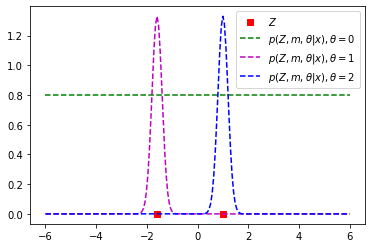

In [62]:
from scipy.stats import norm
from math import factorial

def g(z, x, sigma=0.2):
    '''return object measurement as a realization
    from 1d gaussian ()'''
    return norm.pdf(z, x, sigma)

def lamc(z, value=0.3, region=5):
    '''return uniformly distributed clutter intesity
    defined within +/- 1d region value'''
    lam = 0
    if np.abs(z) <= region:
        lam = value
    return lam

def pZd(zs, thetas, x, pd, g, **kwargs):
    '''return measurement likelihood'''
    m = len(zs)
    lams = [lamc(z, **kwargs) for z in zs]
    p_total = 0
    for t in thetas:
        if t > m:
            p = 0
        elif t == 0:
            p = 1 - pd
        else:
            p = pd * g(zs[t-1], x) / lams[t-1]
        p_total += p
    return p_total

pd = 0.2
Z = [-1.6, 1]

xs = np.linspace(start=-6, stop=6, num=200)
params = {"value": 0.3, "region": 5}
ps0 = [pZd(Z, [0], x, pd, g, **params) for x in xs]
ps1 = [pZd(Z, [1], x, pd, g, **params) for x in xs]
ps2 = [pZd(Z, [2], x, pd, g, **params) for x in xs]
ps_total = [pZd(Z, [0,1,2], x, pd, g, **params) for x in xs]

ax = plt.axes()
ax.plot(Z, [0] * len(Z), "rs", label=r"$Z$")
ax.plot(xs, ps0, "g--", label=r'$p(Z,m,\theta|x), \theta=0$')
ax.plot(xs, ps1, "m--", label=r'$p(Z,m,\theta|x), \theta=1$')
ax.plot(xs, ps2, "b--", label=r'$p(Z,m,\theta|x), \theta=2$')
#ax.plot(xs, ps_total, "k", label=r'$p(Z|x)$')
ax.legend()
plt.show()

### Filtering with complete SOT model example
Object likelihood $g_k(o_k|x_k)$ could be for example Gaussian $\mathcal{N}(o_k:x_k,0.2)$

Clutter intensity in region bound by $c_{max}$ (range or area for 1d and 2d respectively) 

$$\lambda(c) = \begin{cases} 0.4 &\text{if }|x| \le c_{max} \\ 0 &\text{otherwise} \end{cases}$$

Sequence of measurements $Z_{1:k} = (Z_1, Z_2, ..., Z_k)$ for example, a sequence of 3 measurements could be $Z_1 = [-1.3, 1.7]$, $Z_2 = [1.3]$ and $Z_3 =[-0.3, 2.3]$

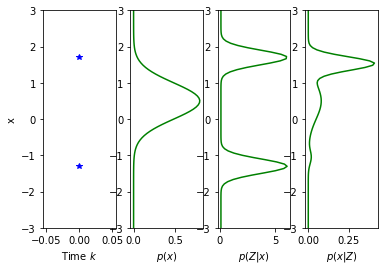

In [82]:
def draw_measurements_k(ax, Z, k, prior_x):
    '''draw 1d measurements versus time'''
    ax.plot([k] * len(Z[k]), Z[k], "b*")

def g(z, x, sigma=0.2):
    '''return object measurement as a realization
    from 1d gaussian ()'''
    return norm.pdf(z, x, sigma)

pd = 0.9
lambda_params = {"value": 0.4, "region": 4}
xs = np.linspace(-3, 3, 100)
Z = [
    [-1.3, 1.7],
    [1.3],
    [-0.3, 2.3]]
k = 0
thetas = range(len(Z[k]) + 1)
prior = norm.pdf(xs, 0.5, 0.5)
likelihood = [pZd(Z[k], thetas, x, pd, g, **params) for x in xs]
posterior = likelihood * prior

# measurements
ax1 = plt.subplot(141)
draw_measurements_k(ax1, Z, k, [])
ax1.set_ylim((-3,3))
ax1.set_ylabel(r"x")
ax1.set_xlabel(r"Time $k$")

# prior
ax2 = plt.subplot(142, sharey=ax1)
ax2.plot(prior, xs,"g")
ax2.set_xlabel(r"$p(x)$")

# likelihood
ax3 = plt.subplot(143, sharey=ax1)
ax3.plot(likelihood, xs,"g")
ax3.set_xlabel(r"$p(Z|x)$")

# posterior
ax4 = plt.subplot(144, sharey=ax1)
ax4.plot(posterior, xs,"g")
ax4.set_xlabel(r"$p(x|Z)$")
plt.show()

## General SOT filtering equations

### Intro
The goal of this part is to derive exact filtering equations. What we mean by this is a set of equations that describe how to recursively compute the posterior of the state at time k given measurements up until and including time k $p(x_k|Z_{1:k})$.

Let sequence of measurements and data association hypotheses up to time $k$ be respectively $Z_{1:k} = (Z_1,Z_2, ..., Z_k)$ and $\theta_{1:k} = (\theta_1,\theta_2, ..., \theta_k)$. The posterior $p(x_k|Z_{1:k})$ in SOT needs to evaluate all data association hypothesis sequences. The derivation uses the law of total probability. The new random variable $\theta_{1:k}$ is introduced to create a new joint distribution $p(x_k, \theta_{1:k}|Z_{1:k})$ and the $p(x_k|Z_{1:k})$ becomes the marginalized density of that distribution. Finally the joint distribution is factored into two parts described shortly that we can derrive on their own later.

$$
p(x_k|Z_{1:k}) = 
\sum_{\theta_{1:k}}p(x_k, \theta_{1:k}|Z_{1:k}) = 
\sum_{\theta_{1:k}}
\underbrace{p(x_k|Z_{1:k},\theta_{1:k})}_{\text{posterior with a}\atop\text{ known hypothesis}}
\underbrace{Pr(\theta_{1:k}|Z_{1:k})}_{\text{probability of}\atop\text{the hypothesis}}
$$

The term $p(x|Z_{1:k},\theta_{1:k})$ is the density of object state given all the measurements and the specific sequence of data association hypotheses. In this density we assume that we know which of the measurements are the object detections, as in the object tracking with known associations. $Pr(\theta_{1:k}|Z_{1:k})$ is the probability mass function (discrete) of the data association hypothesis given the measurements. This factor scales the different densities and gives smaller weights to the unlikely sequences of hypotheses.

*Note: the derivation precisely follows the steps that was used earlier about the complete measurement model. First we identify variables that can simplify things for us. Then we use the law of total probability to introduce them, and finally, we factorize the distribution.*

The derrivation of the predicted density follows exactly the same logic. Note however that the hypotheses sequences in the sum do not change, because in the prediction step we have not introduced any measurements, and we predict based on the past knowledge on the data associations.

$$
p(x_{k+1}|Z_{1:k}) = 
\sum_{\theta_{1:k}}
\underbrace{p(x_{k+1}|Z_{1:k},\theta_{1:k})}_{\text{predicted density with a}\atop\text{ known hypothesis}}
\underbrace{Pr(\theta_{1:k}|Z_{1:k})}_{\text{probability of}\atop\text{the hypothesis}}
$$

At time $k$ there are $m_k + 1$ data association hypotheses. Think of them as how to connect the current association seqeunce or a track to new $m_k$ object detection possibilities also considering that there is no object detected. The number of possible association sequences at time $k$ grows **very quickly** with k.

$$
\prod_{i=1}^k(m_i + 1)
$$

Key idea: **the posterior is a weighted sum of posteriors with known hypothese sequences**. 

What we know so far: 
- how to calculate the posterior likelihood with given association for time $k$

What are missing: 
- posterior density with given association for times $1:k$
- probability of the data association sequence $Pr[\theta_{1_k}|Z_{1:k}]$.

So lets work towards those goals

### Single update step as a sum of hypotheses
To re-cap, given the prior $p(x)$ and the complete measurement likelihood for step $k$ 

$$
p(Z,m,\theta|x) = \sum_{\theta_k=0}^{m_k}p(Z_k, m_k, \theta_k|x_k)
$$
The posterior density according the Bayes rule is proportional to the following expression($k$ ommited for clarity):

$$
p(x|Z) \propto p(x)p(Z|x) = \sum_{\theta = 0}^m 
\underbrace{p(x)p(Z,m,\theta|x)}_{g_{\theta}(x)}
$$

To find the actual posterior density we need to **normalize** the expression, at the same time it would be very useful to factor it in an intuitive way using the principles in the previous chapter so that:
- weights are probabilites of different data association hypotheses
- pdfs are posterior densities given a specific data associations

$$
p(x|Z) = \sum_{\theta=0}^m w_{\theta}p_{\theta}(x)
$$

where $w_{\theta}$ is a probability mass function (discrete) $Pr[\theta|Z]$ that describes the probability of data association $\theta$ with known measurement. $p_{\theta}(x)$ is a pdf $p(x|\theta,Z)$ posterior of $x$ with known $\theta$.

### Normalization of a density mixture
Lets take a side step and figure out how to normalize a general mixture of densities. Consider a PDF $p(x)$ that is proportional to another density $g(x)$ that is a mixture of a sum of densities $g_{\theta}$ where $\theta \in {0, 1, ..., m}$. All mixture componens are non-negative functions with finite intergral or area under the curve. 
$$
p(x) \propto g(x) = \sum_{\theta=0}^{m}g_{\theta}(x)
$$
Our goal is to express p(x) as a mixture of PDF as follows:
$$
p(x) = \sum_{\theta=0}^{m}w_{\theta}p_{\theta}(x)
$$

Lets start simple and consider a normalization of a function. For $p(x) \propto g(x)$ there is a constant $c$ such that $p(x) = cg(x)$. Given that $p(x)$ is a PDF that by definition has unit area the constant can be found.

$$
\int p(x)dx = c \int g(x)dx = 1
\Rightarrow c = \frac{1}{\int g(x)dx}
\Rightarrow p(x) = g(x)\frac{1}{\int g(x)dx}
$$

Also we can notice the fact that an arbitrary density $g_{\theta}(x)$ can be represented as a PDF $p_{\theta}(x)$ and unnormalized weight $\tilde{w}_{\theta}$. 
$$
\tilde{w}_{\theta} = \int g_{\theta}(x)dx \\
p_{\theta}(x) = \frac{g_{\theta}(x)}{\tilde{w}_{\theta}} \\
g_{\theta}(x) = \tilde{w}_{\theta}p_{\theta}(x)
$$


Plugging this result into the mixture we obtain the sum over factorization of each mixture components as follows:
$$
p(x) \propto g(x) = \sum_{\theta=0}^{m}g_{\theta}(x) = \sum_{\theta=0}^{m}\tilde{w}_{\theta}p_{\theta}(x)
$$
The very last step is figure out the factor to normalize $g(x)$. Combining all previously derived expressions for the factorization and weights we get:
$$
c = \int g(x)dx = \sum_{\theta=0}^m\int g_{\theta}(x)dx = \sum_{\theta=0}^m\tilde{w}_{\theta}
$$

This tells us that to normalize $g(x)$ it is **sufficient to normalize the unnormalized weights** as follows:
$$
w_{\theta} = \frac{\tilde{w}_{\theta}}{\sum_{\theta=0}^m\tilde{w}_{\theta}} \\
p(x) = \frac{\sum_{\theta=0}^m\tilde{w}_{\theta}p_{\theta}(x)}{\sum_{\theta=0}^m\tilde{w}_{\theta}} =
\sum_{\theta=0}^m w_{\theta}p_{\theta}(x)
$$
Note: the difference between $w_{\theta}$ and $\tilde{w}_{\theta}$ is that $w_{\theta}$ sum to 1.

So, to re-cap, if we know the mixture components $g_{\theta}$ that compose $g(x)$ we can find $p(x) \propto g(x)$ by finding first the unnormalized weight $\tilde{w}_{\theta}$ which leads to finding mixture PDF componens $p_{\theta}$ and normalized weights $w_{\theta}$ that can be combined into $p(x)$.

Consider an example:

unnormalized weights: wt1:  0.44589719890282664  wt2:  0.9597097075009733  wt3  0.5297242195109074
Area under g_x:  1.9353311259147075
normalized weights: w1:  0.2303984020781351  w2:  0.49588915025969  w3  0.27371244766217495
Area under p_x:  1.0000000000000002


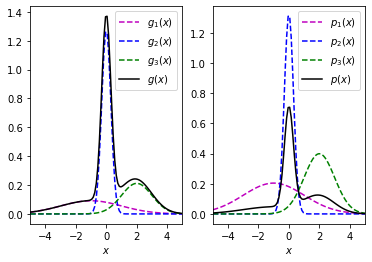

In [123]:
# mixture distribution
x = np.linspace(-5,5,100)
g1 = norm.pdf(x, -1, 2) * rand()
g2 = norm.pdf(x, 0, 0.3) * rand()
g3 = norm.pdf(x, 2, 1) * rand()
g = g1 + g2 + g3

# unscaled wights
wt1 = np.trapz(g1, x)
wt2 = np.trapz(g2, x)
wt3 = np.trapz(g3, x)
print("unnormalized weights: wt1: ",wt1," wt2: ", wt2," wt3 ", wt3)
print("Area under g_x: ", np.trapz(g, x))

# mixture pdfs
p1 = g1 / wt1
p2 = g2 / wt2 
p3 = g3 / wt3

# normalized weights
sumwt = wt1 + wt2 + wt3
w1 = wt1 / sumwt
w2 = wt2 / sumwt
w3 = wt3 / sumwt
print("normalized weights: w1: ",w1," w2: ", w2," w3 ", w3)

# normalized mixture
p = w1*p1 + w2*p2 + w3*p3
print("Area under p_x: ", np.trapz(p, x))

ax = plt.subplot(121)
ax.plot(x, g1, "m--", label=r"$g_1(x)$")
ax.plot(x, g2, "b--", label=r"$g_2(x)$")
ax.plot(x, g3, "g--", label=r"$g_3(x)$")
ax.plot(x, g, "k", label=r"$g(x)$")
ax.set_xlabel(r"$x$")
ax.set_xlim((np.min(x), np.max(x)))
plt.legend()

ax = plt.subplot(122)
ax.plot(x, p1, "m--", label=r"$p_1(x)$")
ax.plot(x, p2, "b--", label=r"$p_2(x)$")
ax.plot(x, p3, "g--", label=r"$p_3(x)$")
ax.plot(x, p, "k", label=r"$p(x)$")
ax.set_xlabel(r"$x$")
ax.set_xlim((np.min(x), np.max(x)))
plt.legend()

plt.show()

#### Back to the factorization of the posterior
We have got an intuition of how to obtain a posterior PDF using the factorization into weights and mixture component PDFS.
$$
p(x|Z) \propto p(x)p(Z|x) = \sum_{\theta = 0}^m 
\underbrace{p(x)p(Z,m,\theta|x)}_{g_{\theta}(x)} = 
\sum_{\theta=0}^m w_{\theta}p_{\theta}(x)
$$

Applying the law of total probability one can obtain an individual expression for $w_{\theta}p_{\theta}(x)$:
$$
p(x,Z) = 
\sum_{\theta=1}^{m}p(x,\theta|Z) = 
\sum_{\theta=1}^{m}w_{\theta}p_{\theta}(x)
\Rightarrow p(x, \theta|Z) = w_{\theta}p_{\theta}(x)
$$
Based on this results we can draw a few interesting conclusions:
- integrating over $x$ on both sides of the equation we find that the normalized weights are data association probabilities $$w_{\theta} = Pr(\theta|Z)$$
- dividing both sides by normalized weights and using the [definition of conditional distributions](https://en.wikipedia.org/wiki/Conditional_probability_distribution) we find that the PDFs in the factorization are indeed conditional posterior PDFs
$$p_{\theta}(x) = \frac{p(x,\theta|Z)}{w_{\theta}} = \frac{p(x,\theta|Z)}{Pr(\theta|Z)} = p(x|\theta, Z)$$

### Back to general equations

The goal is to derive $p(x|Z) = \sum_{\theta=0}^m w_{\theta}p_{\theta}(x)$ for general models defined by:
- prior $p(x)$
- probability of detection $P^D(x)$
- clutter intensity function $\lambda_c(c)$
- sensor model $g(o|x)$

Considering the complete measurement model $p(Z|x)$ notice that the last part is independent on $x$ and thus only affects the normalization that we will solve in a new way presented above.
$$
p(x|Z) \propto p(x)p(Z|x) \propto p(x) \left[
(1 - P^D(x)) + \sum_{\theta=1}^{m}P^D(x)\frac{g_{k}(z^{\theta}|x)}{\lambda_{c}(z^{\theta})}
\right]
$$

It is desired to represent this posterior as $p(x|Z) = \sum_{\theta=0}^m w_{\theta}p_{\theta}(x)$

Consider follwing example:
3 hypotheses



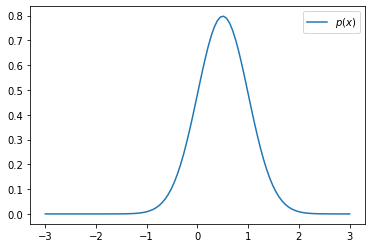

In [135]:
px = lambda x: norm.pdf(x, 0.5, 0.5)
pd = lambda x: 0.85
go = lambda o, mean: norm.pdf(o, mean, 0.2)
lamc = lambda c: 0.3 if np.abs(c) < 5 else 0

Z = [-1.6, 1]

# measurement likelihoods for 3 hypotheses

# unnormalized weights

# pds for hypotheses pti

# normalized weights wti

# posterior
x = np.linspace(-3,3,100)
p = px(x)
plt.plot(x,p,label=r'$p(x)$')
plt.legend()
plt.show()

